In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import  *
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset_path = '/content/drive/MyDrive/Monument_Final_Data/train'
validation_dataset_path = '/content/drive/MyDrive/Monument_Final_Data/val'

In [ ]:
for dirname,_,files in os.walk(validation_dataset_path):
    print(f"{dirname.split('/')[-1]}: {len(files)}")

val: 0
Amber Fort: 33
Brihadeeswarar Temple: 43
Fatehpur Sikri: 35
Golden Temple: 84
Hawa Mahal: 73
Humayun Tomb: 61
Lotus Bahai Temple: 41
Meenakshi Amman Temple: 51
Mysore Palace: 40
Purana Qila: 36
Qutab Minar, Delhi: 54
Safdarjung's Tomb: 38
Sanchi Stupa: 34
Taj Mahal: 64
Virupaksha Temple: 59


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 10297 images belonging to 15 classes.
Found 746 images belonging to 15 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Amber Fort
1 : Brihadeeswarar Temple
2 : Fatehpur Sikri
3 : Golden Temple
4 : Hawa Mahal
5 : Humayun Tomb
6 : Lotus Bahai Temple
7 : Meenakshi Amman Temple
8 : Mysore Palace
9 : Purana Qila
10 : Qutab Minar, Delhi
11 : Safdarjung's Tomb
12 : Sanchi Stupa
13 : Taj Mahal
14 : Virupaksha Temple


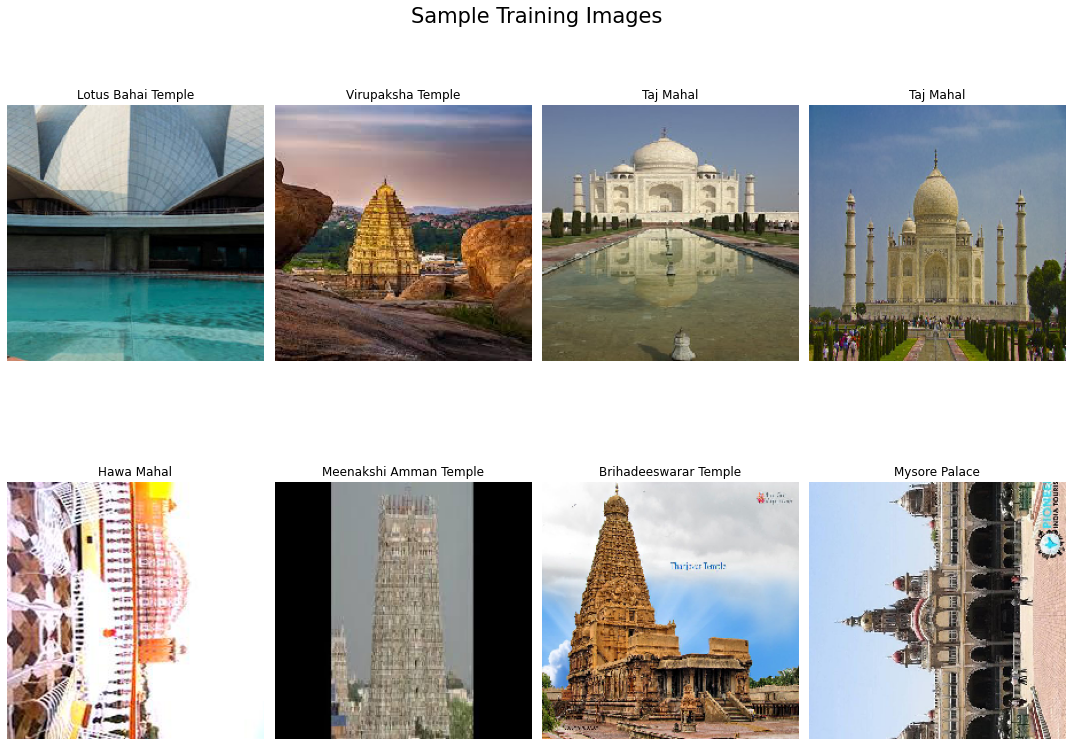

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet50_model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
resnet50_model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
av1=GlobalAveragePooling2D()(resnet50_model.output)
fc1=Dense(1024,activation='relu')(av1)
d1=Dropout(0.5)(fc1)
fc2=Dense(15,activation='softmax')(d1)

res50model_new=Model(inputs=resnet50_model.input,outputs=fc2)
res50model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
res50model_new.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= ['accuracy'],
)

In [ ]:
for ix in range(len(res50model_new.layers)):
    print(ix,res50model_new.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7f0cd4c36040>
1 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0d47cab580>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0cd4f4ebe0>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0cd4c00d00>
4 <keras.layers.core.activation.Activation object at 0x7f0cd4c5b8e0>
5 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0cd4c1e820>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0cd37f8640>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0cd37f8670>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0cd3808f70>
9 <keras.layers.core.activation.Activation object at 0x7f0cd380e6d0>
10 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f0cd3814f70>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0cd3814940>
12 <keras.layers.core.activation.Activation object at 0x7f0cd

In [ ]:
# Freezeing layer upto 169 layer
# for ix in range(169):
#     res50model_new.layers[ix].trainable=False
# res50model_new.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss= keras.losses.CategoricalCrossentropy(from_logits = True),
#     metrics= ['accuracy'],
# )
# res50model_new.summary()

In [ ]:
epochs = 10
history_resnet=res50model_new.fit(train_generator,shuffle = True, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


322/322 [==============================] - 8242s 26s/step - loss: 1.0603 - accuracy: 0.6965 - val_loss: 15.4878 - val_accuracy: 0.0724
Epoch 2/10
322/322 [==============================] - 173s 535ms/step - loss: 0.4030 - accuracy: 0.8773 - val_loss: 5.3165 - val_accuracy: 0.1113
Epoch 3/10
322/322 [==============================] - 171s 532ms/step - loss: 0.2774 - accuracy: 0.9167 - val_loss: 0.8035 - val_accuracy: 0.8097
Epoch 4/10
322/322 [==============================] - 171s 531ms/step - loss: 0.1963 - accuracy: 0.9410 - val_loss: 2.8077 - val_accuracy: 0.5134
Epoch 5/10
322/322 [==============================] - 170s 528ms/step - loss: 0.1657 - accuracy: 0.9484 - val_loss: 3.5941 - val_accuracy: 0.5201
Epoch 6/10
322/322 [==============================] - 170s 527ms/step - loss: 0.1598 - accuracy: 0.9517 - val_loss: 1.6698 - val_accuracy: 0.6930
Epoch 7/10
322/322 [==============================] - 169s 525ms/step - loss: 0.1474 - accuracy: 0.9539 - val_loss: 0.7879 - val_accura

In [ ]:
res50model_new.save("/content/drive/MyDrive/Monument_Final_Data/resnet50.h5")

In [ ]:
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']

train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

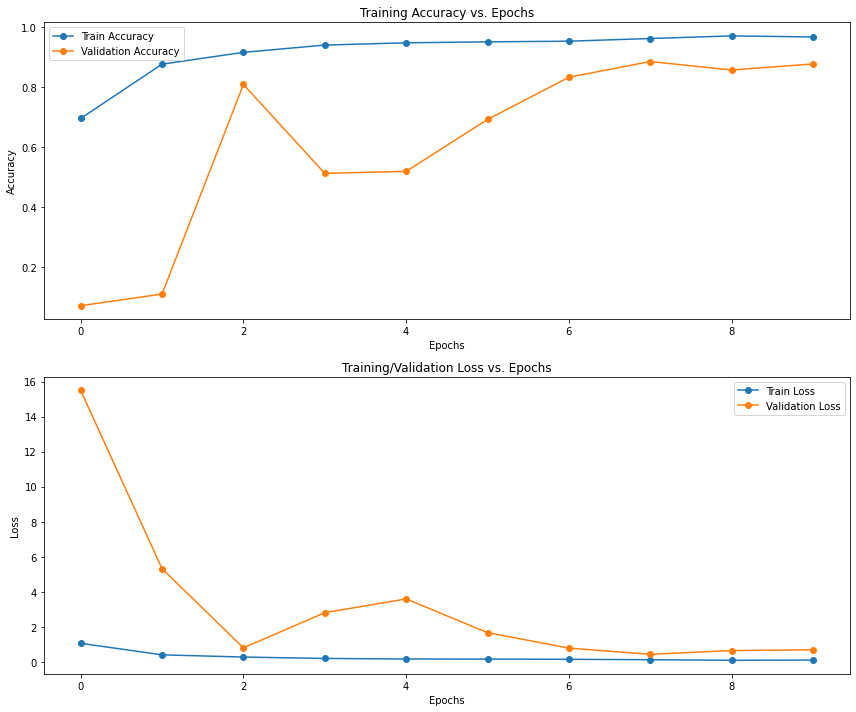

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
test_dataset = '/content/drive/MyDrive/Monument_Final_Data/test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 251 images belonging to 15 classes.


8/8 [==============================] - 2s 288ms/step


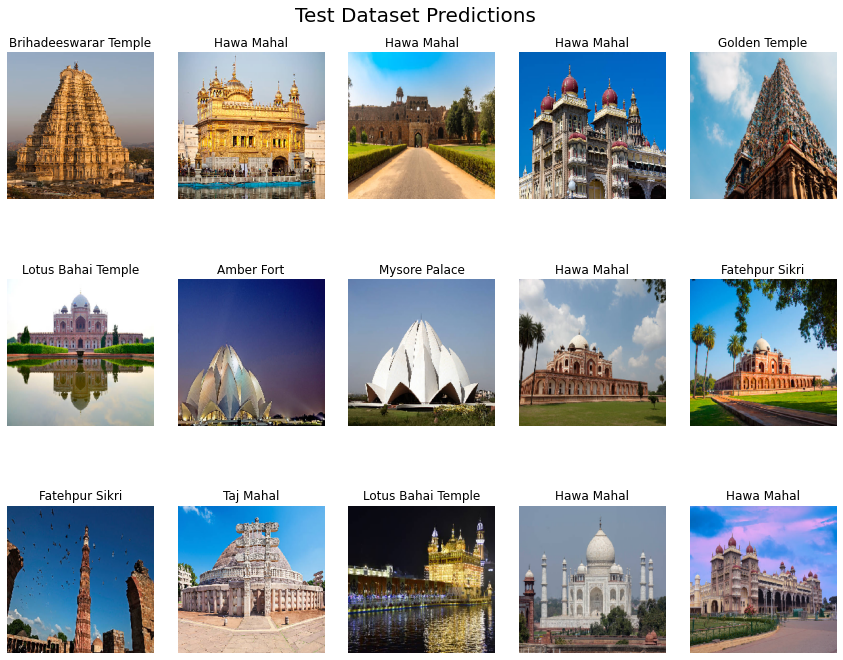

In [ ]:
predictions = res50model_new.predict(test_generator)
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
idx = 0

for i in range(3):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = res50model_new.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 3s 324ms/step - loss: 0.5975 - accuracy: 0.8526


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.5974953174591064
Test Accuracy: 0.8525896668434143


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

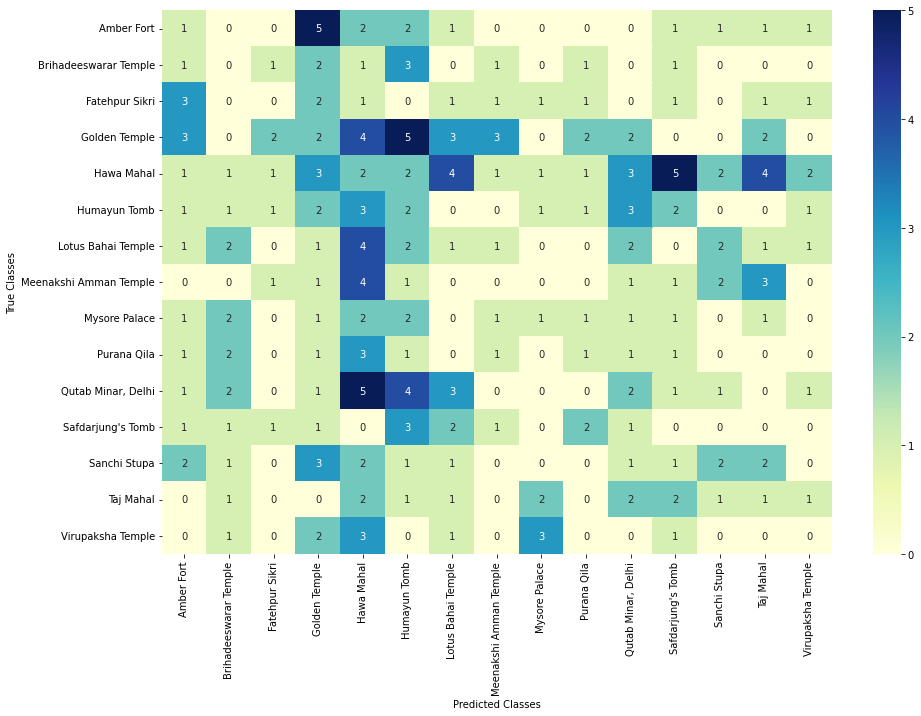

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)
# print(cf_mtx)
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}" for v1 in group_counts]
box_labels = np.asarray(box_labels).reshape(15, 15)

plt.figure(figsize = (15, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                        precision    recall  f1-score   support

            Amber Fort       0.06      0.07      0.06        15
 Brihadeeswarar Temple       0.00      0.00      0.00        11
        Fatehpur Sikri       0.00      0.00      0.00        13
         Golden Temple       0.07      0.07      0.07        28
            Hawa Mahal       0.05      0.06      0.06        33
          Humayun Tomb       0.07      0.11      0.09        18
    Lotus Bahai Temple       0.06      0.06      0.06        18
Meenakshi Amman Temple       0.00      0.00      0.00        14
         Mysore Palace       0.11      0.07      0.09        14
           Purana Qila       0.10      0.08      0.09        12
    Qutab Minar, Delhi       0.11      0.10      0.10        21
     Safdarjung's Tomb       0.00      0.00      0.00        13
          Sanchi Stupa       0.18      0.12      0.15        16
             Taj Mahal       0.06      0.07      0.07        14
     Virupaksha Temple       0.00      

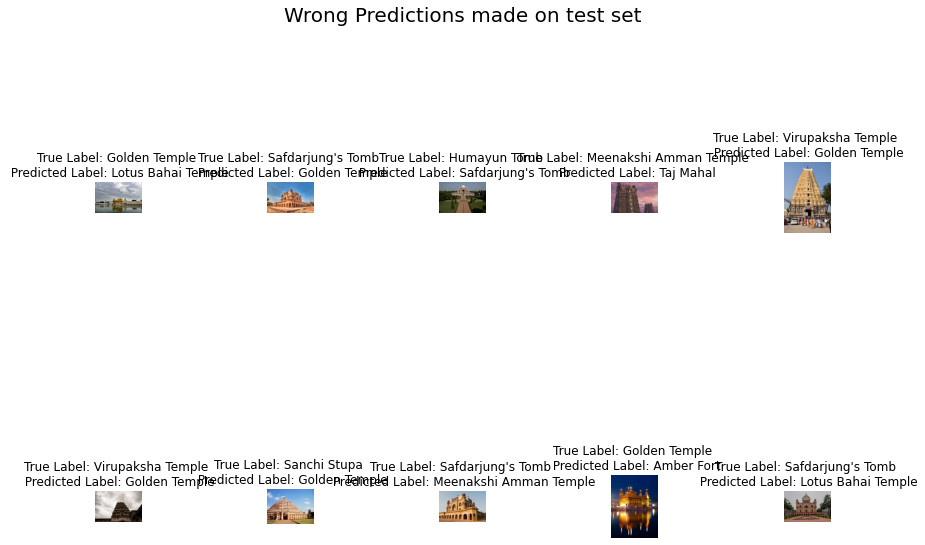

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [ ]:
def predictor(img, model):
    actual_name=img.split('/')[-2]
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print(f'The given image is of \nActual Label: {actual_name} \nPredicted Label: {name}')

1/1 [==============================] - 1s 1s/step
The given image is of 
Actual Label: Safdarjung's Tomb 
Predicted Label: Safdarjung's Tomb


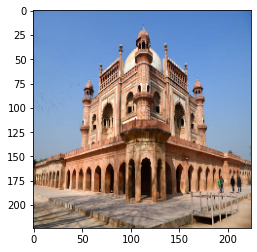

In [ ]:
predictor("/content/drive/MyDrive/Monument_Final_Data/test/Safdarjung's Tomb/gettyimages-906858906-612x612.jpg", res50model_new)

1/1 [==============================] - 0s 24ms/step
The given image is of 
Actual Label: Amber Fort 
Predicted Label: Hawa Mahal


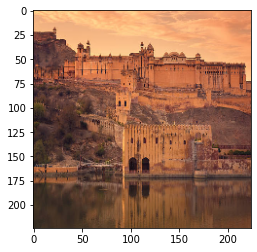

In [ ]:
predictor('/content/drive/MyDrive/Monument_Final_Data/test/Amber Fort/gettyimages-636953070-612x612.jpg', res50model_new)